_In the previous notebook, we pre-processed the data and saved it to a file. In this notebook, we will load the data and train a model to predict the generation of a Solar Power Plant._

## OBJECTIVES
- We'll use 80% of the data to train our model to predict the "UTILIZATION" value based on "IRRADIATION", "TEMPERATURE", "MODULE_TEMPERATURE", "DATE_TIME", etc.
- We'll randomly select an unseen day and have it predict the "UTILIZATION", then summate to get total daily units.
- If predicted total daily units is significantly greater than the actual output on that day, the fault percentage will be high, and will cross the threshold.
- This system can alert a Solar Power Plant's maintenance crew if the panels need cleaning or maintenance.
- In the long term, it's beneficial to measure the amount of dust that accumulates over the panels and at what rate throughout the year.
- We want to build a model that can help us achieve a completely maintenance free Solar Power Plant, leaving only faults in the system to be dealt by human maintenance crew.

In [7]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [8]:
# Load the data
data = pd.read_csv('data/combined_data2.csv')

data["DATE_TIME"] = pd.to_datetime(data["DATE_TIME"])

# Exclude all rows where the value of "DC_POWER" is 0
data = data[data["DC_POWER"] != 0]

# Print info about the data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 68859 entries, 510 to 136031
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            68859 non-null  datetime64[ns]
 1   SOURCE_KEY           68859 non-null  object        
 2   DC_POWER             68859 non-null  float64       
 3   AC_POWER             68859 non-null  float64       
 4   DAILY_YIELD          68859 non-null  float64       
 5   TOTAL_YIELD          68859 non-null  float64       
 6   AMBIENT_TEMPERATURE  68859 non-null  float64       
 7   MODULE_TEMPERATURE   68859 non-null  float64       
 8   IRRADIATION          68859 non-null  float64       
 9   UTILIZATION          68859 non-null  float64       
 10  DC_CAPACITY          68859 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 6.3+ MB
None


## Note
- We need to make sure we are able to save the model as a file and load it up again for deployment in our API
- Later in this notebook we'll write sample code to load the model and use it with a single value

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'data' is your DataFrame
# Convert DATE_TIME to datetime if it's not already
data['DATE_TIME'] = pd.to_datetime(data['DATE_TIME'])

# Split the data into train and test sets
test_data = data[data['DATE_TIME'] < pd.to_datetime('2020-05-20')]
train_data = data[data['DATE_TIME'] >= pd.to_datetime('2020-05-20')]

print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

# print(train_data.sample(5, random_state=42))
# print(test_data.sample(5, random_state=42))

# Define the feature columns and target column
feature_cols = ['IRRADIATION', 'AMBIENT_TEMPERATURE', 'DC_CAPACITY']
target_col = 'UTILIZATION'

# Create the train and test datasets
X_train = train_data[feature_cols]
y_train = train_data[target_col]
X_test = test_data[feature_cols]
y_test = test_data[target_col]

print(f'X_train:{X_train.shape}, y_train:{y_train.shape}')
print(f'X_test:{X_test.shape}, y_test:{y_test.shape}')

# # Sample of 5 random rows from X_train and X_test
# print(X_train.sample(5, random_state=42))
# print(X_test.sample(5, random_state=42))

# # Sample of 5 random rows from y_train and y_test
# print(y_train.sample(5, random_state=42))
# print(y_test.sample(5, random_state=42))


# Create the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Assess the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Choose some random indices, then compare the actual values to the predicted values
indices = [0, 500, 1000, 1500, 2000]
for index in indices:
    actual = y_test.iloc[index]
    predicted = y_pred[index]
    print(f'Actual: {actual}, Predicted: {predicted}')

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

Train data shape: (58704, 11)
Test data shape: (10155, 11)
X_train:(58704, 3), y_train:(58704,)
X_test:(10155, 3), y_test:(10155,)
Actual: 0.0023652026262305, Predicted: 0.0037974007927121666
Actual: 0.4201782465548809, Predicted: 0.49916119480770826
Actual: 0.150743005467785, Predicted: 0.14701248650126636
Actual: 0.6183640328273717, Predicted: 0.600963320778567
Actual: 0.1805195420034379, Predicted: 0.17305702801743955
Mean Squared Error: 0.005282901516838994
R2 Score: 0.9082115549499663


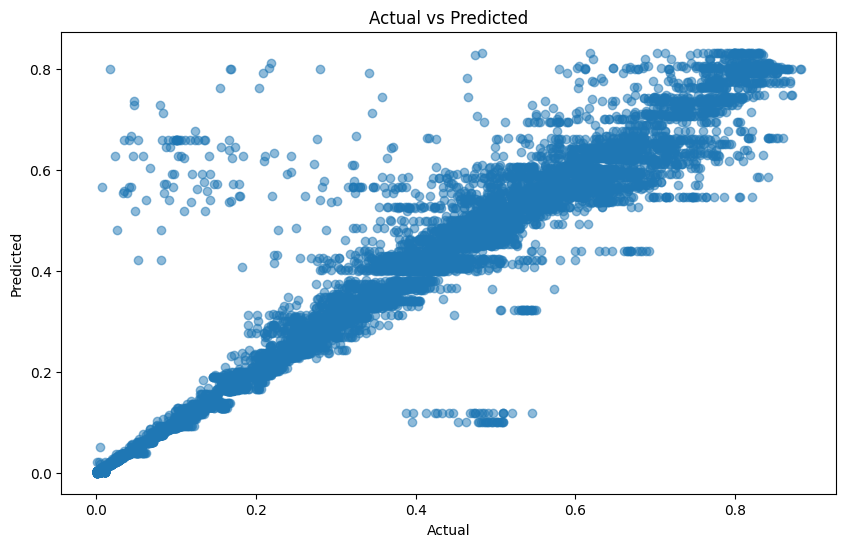

In [10]:
# Make a plot of the actual values vs the predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Create the model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(len(feature_cols),)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# X data is not normalized
# Normalize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Make predictions
y_pred = model.predict(X_test)

# Assess the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Choose some random indices, then compare the actual values to the predicted values
for index in indices:
    actual = y_test.iloc[index]
    predicted = y_pred[index]
    print(f'Actual: {actual}, Predicted: {predicted}')

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

Epoch 1/10


c:\Users\karth\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1835/1835 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0055
Epoch 2/10
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0041
Epoch 3/10
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0040
Epoch 4/10
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0038
Epoch 5/10
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0039
Epoch 6/10
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0037
Epoch 7/10
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0040
Epoch 8/10
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0038
Epoch 9/10
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0037
Epoch 10/10
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0038
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Actual: 0.0023652026262305, Predicted: [0.02445683]
Actual: 0.4201782465548809, Predicted: [0.4961378]
Actual: 0.150743005467785, Predicted: [0.16973345]
Actual: 0.6183640328273717, Predicted: [0.56988674]
Actual: 0.1805195420034379, Predicted: [0.18150619]
Mean Squared Error: 0

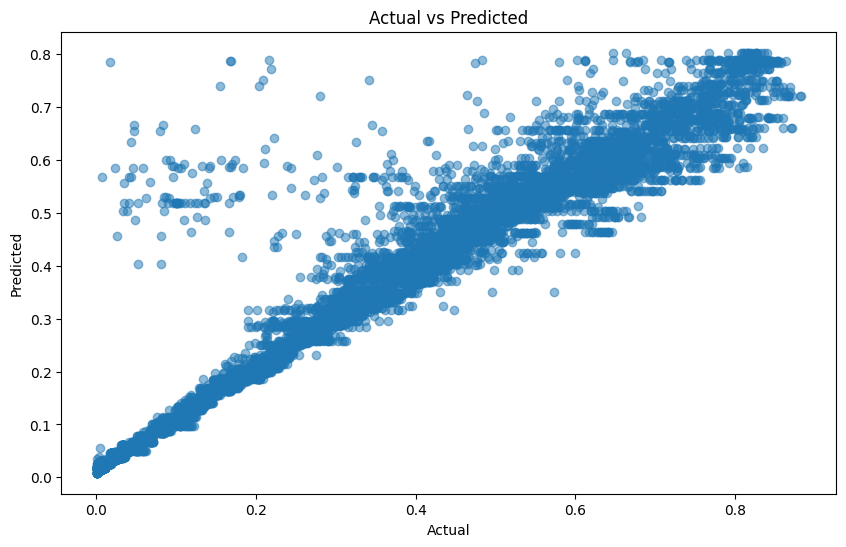

In [12]:
# Make a plot of the actual values vs the predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()